In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras as kr
from tensorflow.keras import optimizers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
# upload
print('Uploading...')
exp_matrix = pd.read_csv('/root/work/multi/brca_exp', index_col=0)
label_surv = pd.read_csv('/root/work/multi/brca_label_surv', index_col=0)
label_t = pd.read_csv('/root/work/multi/brca_label_type', index_col=0)
print('Uploading done!')

Uploading...
Uploading done!


In [3]:
# data preprocessing
x = exp_matrix.T

# str -> int
y1 = np.array(label_surv['survival_label'].map({'LTS':0, 'STS':1}).astype(int)).reshape(label_surv.shape[0],1)
y2 = np.array(label_t['BRCA_Subtype_PAM50'].map({'LumA':0, 'LumB':1, 'Basal':2, 'Her2':3, 'Normal':4}).astype(int))

# int -> onthot
y2 = kr.utils.to_categorical(y2)

In [4]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(train)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [5]:
train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())
print(train_x.shape, test_x.shape, train_y1.shape, test_y1.shape, train_y2.shape, test_y2.shape)

(567, 12411) (243, 12411) (567, 1) (243, 1) (567, 5) (243, 5)


In [6]:
model = Sequential()

#input
input_layer = Input((train_x.shape[1],), name='input')

dense_01 = Dense(8192, kernel_initializer='uniform', activation='LeakyReLU', name='dense_01')(input_layer)
# dropout_01 = Dropout(0.1, name='dropout_01')(dense_01)
dense_02 = Dense(4096,kernel_initializer='uniform',activation='relu', name='dense_02')(dense_01)

#surv
concat_surv = Concatenate(name='concat_surv')([dense_02, input_layer])
dense_11 = Dense(128, kernel_initializer='uniform', activation='relu', name='dense_11')(concat_surv)
dropout_11 = Dropout(0.1, name='dropout_11')(dense_11)
dense_12 = Dense(32, kernel_initializer='uniform', activation='relu', name='dense_12')(dropout_11)
#dropout_12 = Dropout(0.1, name='dropout_12')(dense_12)
outputs_1 = Dense(1,kernel_initializer='uniform',activation='sigmoid', name='output_1')(dense_12)

# #subtype
concat_sub = Concatenate(name='dense_21')([dense_02, input_layer])
dense_21 = Dense(1024, kernel_initializer='uniform', activation='relu')(concat_sub)
dropout_21 = Dropout(0.1, name='dropout_21')(dense_21)
dense_22 = Dense(128, kernel_initializer='uniform', activation='relu', name='dense_22')(dropout_21)
dropout_22 = Dropout(0.1, name='dropout_22')(dense_22)
outputs_2 = Dense(5,kernel_initializer='uniform',activation='softmax', name='output_2')(dropout_22)

model = Model(inputs=input_layer, outputs=[outputs_1, outputs_2], name='conbinedModel')

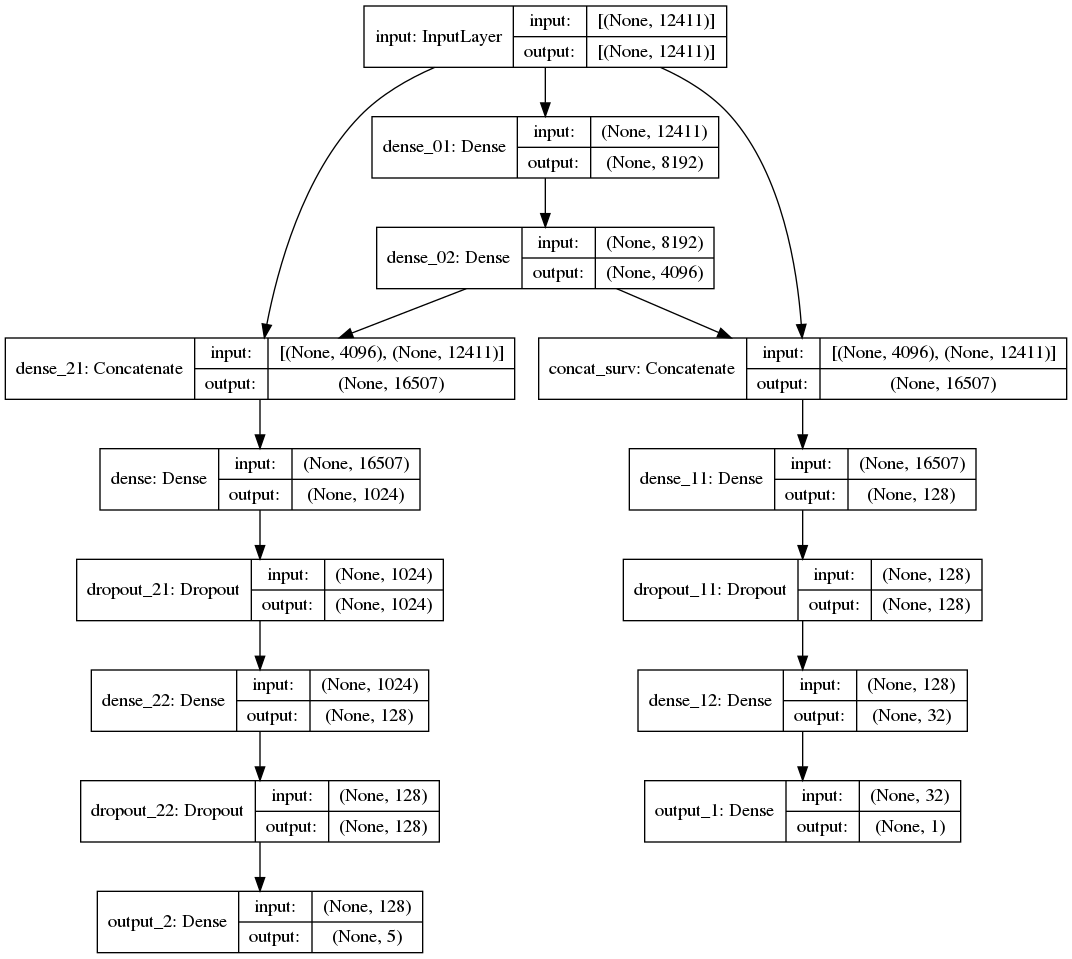

In [7]:
plot_model(model, show_shapes=True)

In [8]:
model.compile(loss={'output_1':kr.losses.BinaryCrossentropy(), 'output_2':kr.losses.CategoricalCrossentropy()},
              loss_weights={'output_1':0.7, 'output_2':0.3},
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
b = 32
train_history=model.fit(train_x,
                        {'output_1':train_y1,'output_2':train_y2},
                        epochs=50,
                        validation_split=0.1,
                        batch_size=b)

Epoch 1/50
16/16 [==============================] - 5s 238ms/step - loss: 4.3029 - output_1_loss: 0.2553 - output_2_loss: 13.7474 - output_1_accuracy: 0.9118 - output_2_accuracy: 0.5353 - val_loss: 0.7959 - val_output_1_loss: 0.0020 - val_output_2_loss: 2.6485 - val_output_1_accuracy: 1.0000 - val_output_2_accuracy: 0.4912
Epoch 2/50
16/16 [==============================] - 3s 214ms/step - loss: 0.5024 - output_1_loss: 0.1658 - output_2_loss: 1.2876 - output_1_accuracy: 0.9765 - output_2_accuracy: 0.7157 - val_loss: 0.4213 - val_output_1_loss: 0.0235 - val_output_2_loss: 1.3495 - val_output_1_accuracy: 1.0000 - val_output_2_accuracy: 0.5965
Epoch 3/50
16/16 [==============================] - 3s 219ms/step - loss: 0.3262 - output_1_loss: 0.1289 - output_2_loss: 0.7866 - output_1_accuracy: 0.9784 - output_2_accuracy: 0.7333 - val_loss: 0.1966 - val_output_1_loss: 0.0068 - val_output_2_loss: 0.6394 - val_output_1_accuracy: 1.0000 - val_output_2_accuracy: 0.7544
Epoch 4/50
16/16 [=========

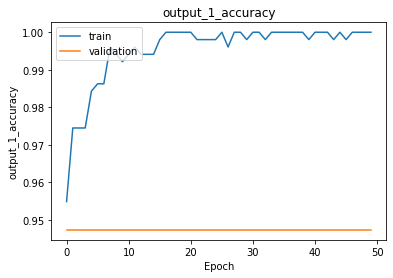

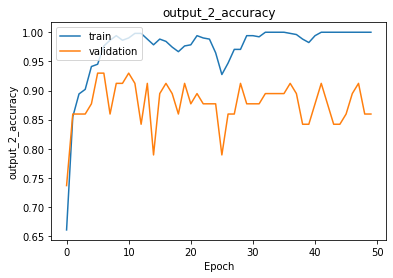

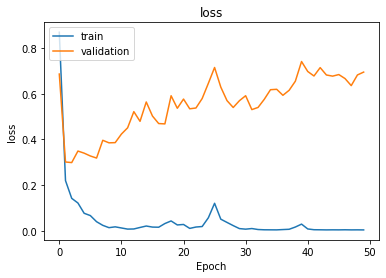

In [10]:
show_train_history(train_history, 'output_1_accuracy', 'val_output_1_accuracy')
show_train_history(train_history, 'output_2_accuracy', 'val_output_2_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [48]:
model.evaluate(x=test_x, y=[test_y1, test_y2])
# print('test loss: ', loss)
# print('test accuracy: ', accuracy)

## 1:0.8361, 2:0.7213 —— 7:3 ——subtype model
## 1:0.8033, 2:0.7377 —— 7:3 ——surv model 
## 1:0.7377, 2:0.9016 —— 85:15

8/8 [==============================] - 0s 6ms/step - loss: 0.1929 - output_1_loss: 0.0996 - output_2_loss: 0.4105 - output_1_accuracy: 0.9918 - output_2_accuracy: 0.9424


[0.19286473095417023,
 0.09958066046237946,
 0.4105275571346283,
 0.991769552230835,
 0.9423868060112]

In [5]:
from keras.models import load_model

# # 保存训练好的model为hdf5文件
# model.save('/root/work/model/brca_multi_model.h5')  
# 重新加载模型
model = load_model('/root/work/model/brca_multi_model.h5')

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = test_y1
y_pred = model.predict(test_x)[0].astype(np.int64)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['LTS','STS'], index=['LTS','STS'])
cm

,LTS,STS
LTS,238,0
STS,5,0


In [46]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.2f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,LTS,STS
LTS,1.0,0.0
STS,1.0,0.0


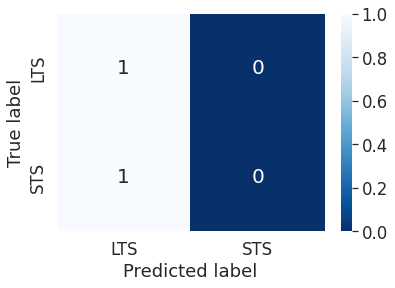

In [47]:
sns.set(font_scale=1.5)
plt.rc('font',size=20)
sns.heatmap(cm,cmap="Blues_r",annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [53]:
y_true = np.argmax(test_y2, axis=-1).reshape(test_y2.shape[0],1)
y_pred = np.argmax(model.predict(test_x)[1].astype(np.int64), axis=-1).reshape(test_y2.shape[0],1)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['LumA', 'LumB', 'Basal', 'Her2', 'Normal'], index=['LumA', 'LumB', 'Basal', 'Her2', 'Normal'])
cm

,LumA,LumB,Basal,Her2,Normal
LumA,128,0,0,0,0
LumB,18,25,0,0,0
Basal,1,0,36,0,0
Her2,14,0,0,7,0
Normal,4,0,0,0,10


In [54]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.3f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,LumA,LumB,Basal,Her2,Normal
LumA,1.000000,0.000000,0.000000,0.000000,0.000000
LumB,0.418605,0.581395,0.000000,0.000000,0.000000
Basal,0.027027,0.000000,0.972973,0.000000,0.000000
Her2,0.666667,0.000000,0.000000,0.333333,0.000000
Normal,0.285714,0.000000,0.000000,0.000000,0.714286


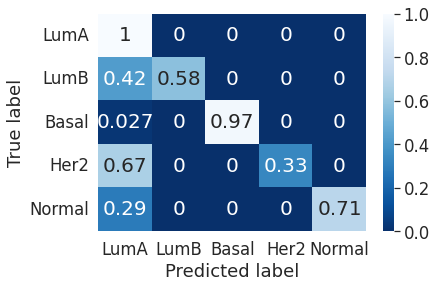

In [55]:
sns.set(font_scale=1.5)
plt.rc('font',size=20)
sns.heatmap(cm,cmap="Blues_r",annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [8]:
model_surv = load_model('/root/work/model/brca_surv_model.h5')
model_sub = load_model('/root/work/model/brca_subtype_model.h5')

m_surv = []
m_sub = []
surv = []
sub = []
for i in range(10):
    train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())

    loss1, loss1_1, loss1_2,  accuracy1_1, accuracy1_2 = model.evaluate(x=test_x, y=[test_y1, test_y2])
    loss2, accuracy2 = model_surv.evaluate(test_x, test_y1)
    loss3, accuracy3 = model_sub.evaluate(test_x, test_y2)
    m_surv.append(accuracy1_1)
    surv.append(accuracy2)
    m_sub.append(accuracy1_2)
    sub.append(accuracy3)

evaluate_result = pd.DataFrame([m_surv, surv, m_sub, sub], index=['m_surv','surv', 'm_sub', 'sub'])
evaluate_result

8/8 [==============================] - 0s 4ms/step - loss: 0.0614 - categorical_accuracy: 0.9918


,0,1,2,3,4,5,6,7,8,9
m_surv,0.987654,0.995885,1.000000,1.000000,0.995885,0.995885,0.987654,1.000000,0.991770,1.000000
surv,0.995885,1.000000,0.995885,0.995885,1.000000,0.995885,0.991770,0.995885,0.995885,1.000000
m_sub,0.962963,0.934156,0.946502,0.958848,0.962963,0.958848,0.967078,0.958848,0.954733,0.950617
sub,0.991770,0.979424,0.991770,0.987654,0.987654,0.987654,0.987654,0.987654,0.995885,0.991770


In [39]:
import keras.backend as K

def Precision_m(model,test_x,test_y):
    y_pred = model.predict(test_x)[0]
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))  # predicted positives
    pp = tf.cast(pp,dtype=tf.float64)
    precision = tp / (pp + K.epsilon())
    return precision

def Recall_m(model,test_x,test_y):
    y_pred = model.predict(test_x)[0]
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(test_y, 0, 1)))  # possible positives
    pp = tf.cast(pp,dtype=tf.float64)
    recall = tp / (pp + K.epsilon())
    return recall

def F1_m(model,test_x,test_y):
    precision = Precision_m(model,test_x,test_y)
    recall = Recall_m(model,test_x,test_y)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

def Precision(model,test_x,test_y):
    y_pred = model.predict(test_x)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))  # predicted positives
    pp = tf.cast(pp,dtype=tf.float64)
    precision = tp / (pp + K.epsilon())
    return precision

def Recall(model,test_x,test_y):
    y_pred = model.predict(test_x)
    tp = K.sum(K.round(K.clip(test_y * y_pred, 0, 1)))  # true positives
    tp = tf.cast(tp,dtype=tf.float64)
    pp = K.sum(K.round(K.clip(test_y, 0, 1)))  # possible positives
    pp = tf.cast(pp,dtype=tf.float64)
    recall = tp / (pp + K.epsilon())
    return recall

def F1(model,test_x,test_y):
    precision = Precision(model,test_x,test_y)
    recall = Recall(model,test_x,test_y)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [40]:
F1_m(model,test_x,test_y1).numpy()

0.9999999333333361

In [43]:
model_surv = load_model('/root/work/model/brca_surv_model.h5')

m_surv = []
surv = []
for i in range(10):
    train_x, test_x, train_y1, test_y1, train_y2, test_y2 = train_test_split(x, y1, y2, test_size=0.3, random_state=np.random.seed())

    m_surv.append(F1_m(model,test_x,test_y1).numpy())
    surv.append(F1(model_surv,test_x,test_y1).numpy())
evaluate_result = pd.DataFrame([m_surv, surv], index=['m_surv','surv'])
evaluate_result

,0,1,2,3,4,5,6,7,8,9
m_surv,0.571429,0.833333,1.000000,1.0,0.909091,1.000000,0.666667,0.888889,0.8,0.666667
surv,0.750000,1.000000,0.909091,1.0,1.000000,0.666667,1.000000,0.750000,0.8,0.909091


In [13]:
import tensorflow as tf
def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[0][:, top_pred_idx]  # surv: preds[0], sub: preds[1]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # # 2. Preprocess the interpolated images
    # interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [14]:
# surv
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[0][0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242


In [15]:
preds = model.predict(test_x)[0]
preds_y = pd.DataFrame(np.where(preds>0.5, 1, 0), columns=['class'])

idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

surv_0 = igs.loc[idx_0]
surv_1 = igs.loc[idx_1]

In [23]:
# LTS
row_mean = pd.DataFrame(surv_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_multi_surv0_igs_mean')

# # STS
# row_mean = pd.DataFrame(surv_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
# row_mean.to_csv('/root/work/multi/stad_multi_surv1_igs_mean')

In [25]:
# sub
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[1][0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [26]:
preds = model.predict(test_x)[1]
preds = np.argmax(preds, axis=1)
preds_y = pd.DataFrame(preds, columns=['class'])

idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()
idx_2 = preds_y.index[preds_y['class']==2].to_list()
idx_3 = preds_y.index[preds_y['class']==3].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

sub_0 = igs.loc[idx_0]
sub_1 = igs.loc[idx_1]
sub_2 = igs.loc[idx_2]
sub_3 = igs.loc[idx_3]

In [28]:
# CIN
row_mean = pd.DataFrame(sub_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub0_igs_mean')

# GS
row_mean = pd.DataFrame(sub_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub1_igs_mean')

# MSI
row_mean = pd.DataFrame(sub_2.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub2_igs_mean')

# EBV
row_mean = pd.DataFrame(sub_3.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/stad_multi_sub3_igs_mean')